## Premier League match results predictions

The aim of this notebookis to predict Premier League match winers wit ML algorithms.
Match statisticts for Premier League 2018 - 2022 seasons were downloaded from https://fbref.com/ website.
Download process is documented in Football_web_scraping notebook.

In [35]:
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def backtest(data, model, predictors, start=2, step=1):
#fit model for each season based on statistics from previous seasons
#return df with all predictions
    
    all_predictions = []
    
    seasons = sorted(data['season'].unique())
    
    season_lenght = len(seasons)
    for i in range(start, season_lenght, step):
        season = seasons[i]
        
        train = data[data['season'] < season]
        test = data[data['season'] == season]
        
        model.fit(train[predictors], train['target'])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        
        combined = pd.concat([test['target'], preds], axis=1)
        combined.columns = ['actual_result', 'prediction']
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [3]:
def add_target(team):
    team['target'] = team['won'].shift(-1)
    
    return team

In [4]:
ROLLING = 10
def find_team_avg(team):
    rolling = team.rolling(ROLLING).mean()
    return rolling

In [5]:
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))

In [6]:
df = pd.read_csv('football_games.csv', index_col=0)
#sort df by date
df = df.sort_values('date').reset_index(drop=True)
# create won column. value 1 if match was won. value 0 if match was lost or drawn
df['won'] = df['performance_gls'] > df['performance_gls_opp']
df['won'] = df['won'].astype(int)

In [7]:
#add target column with result of next match
df = df.groupby("team", group_keys=False).apply(add_target)

In [8]:
df

,performance_gls,performance_ast,performance_pk,performance_pkatt,performance_sh,performance_sot,performance_crdy,performance_crdr,expected_xg,expected_npxg,...,aerial_duels_won_opp,aerial_duels_lost_opp,aerial_duels_won%_opp,team_opp,home_opp,season,date,result,won,target
0,4,4,0,0,27,10,0,0,2.6,2.6,...,17.0,18.0,48.6,Leicester City,0,2018,2017-08-11,W,1,0.0
1,3,3,0,0,6,3,1,0,1.5,1.5,...,18.0,17.0,51.4,Arsenal,1,2018,2017-08-11,L,0,1.0
2,0,0,0,0,4,0,1,0,0.3,0.3,...,17.0,17.0,50.0,Southampton,1,2018,2017-08-12,D,0,0.0
3,0,0,0,0,9,1,1,0,0.4,0.4,...,19.0,23.0,45.2,Everton,1,2018,2017-08-12,L,0,1.0
4,1,1,0,0,9,4,1,0,0.6,0.6,...,23.0,19.0,54.8,Stoke City,0,2018,2017-08-12,W,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,5,4,0,0,19,12,1,0,3.4,3.4,...,6.0,10.0,37.5,Norwich City,1,2022,2022-05-22,W,1,NaN
3036,1,1,0,0,7,5,0,0,1.4,1.4,...,7.0,4.0,63.6,Liverpool,1,2022,2022-05-22,L,0,NaN
3037,0,0,0,0,10,4,4,0,0.9,0.9,...,8.0,10.0,44.4,Crystal Palace,1,2022,2022-05-22,L,0,NaN
3038,3,3,0,0,18,7,1,0,1.9,1.9,...,13.0,20.0,39.4,West Ham United,0,2022,2022-05-22,W,1,NaN


In [9]:
df['target'][pd.isnull(df['target'])] = 9
df = df.copy()
df['target'] = df['target'].astype(int)

C:\Users\aa\AppData\Local\Temp\ipykernel_800\3470679465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][pd.isnull(df['target'])] = 9


In [10]:
#check for missing values. No missing values found
nulls = pd.isnull(df).sum()
nulls[nulls > 0]

Series([], dtype: int64)

In [11]:
removed_col = ['team','team_opp','season', 'date', 'result', 'target' ]
selected_col = df.columns[~df.columns.isin(removed_col)]

In [12]:
scaler = MinMaxScaler()

In [13]:
df[selected_col] = scaler.fit_transform(df[selected_col])

In [14]:
#add rolling averages for each team
df_rolling = df[list(selected_col) + ['team','season', 'result']]
df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_avg)

rolling_cols = [f'{col}_{ROLLING}' for col in df_rolling.columns]
df_rolling.columns = rolling_cols

df = pd.concat([df, df_rolling], axis=1).dropna()

C:\Users\aa\AppData\Local\Temp\ipykernel_800\2718828994.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['result', 'team'], dtype='object')
  rolling = team.rolling(ROLLING).mean()


In [15]:
df['home_next'] = add_col(df, 'home')
df['team_opp_next'] = add_col(df, 'team_opp')
df['date_next'] = add_col(df, 'date')
df = df.copy()

In [16]:
#add columns with statistics for next opponent
full = df.merge(df[rolling_cols + ['team_opp_next', 'date_next', 'team']], 
                left_on=['team', 'date_next'], 
                right_on=['team_opp_next', 'date_next']
               )

In [17]:
#data are imbalanced due to merging loss and draww results into one category
full['won'].value_counts()

0.0    1411
1.0     873
Name: won, dtype: int64

In [31]:
win = round(((full[full['won'] == 1].shape[0] / full['won'].shape[0]) * 100), 1)

print(f'Win % = {round(win, 1)}')
print(f'Loose or draw % = {100 - win}')

Win % = 38.2
Loose or draw % = 61.8


In [19]:
removed_col = list(full.columns[full.dtypes == "object"]) + removed_col
selected_col = full.columns[~full.columns.isin(removed_col)]

In [20]:
removed_col

['team_x',
 'team_opp',
 'date',
 'result',
 'team_opp_next_x',
 'date_next',
 'team_opp_next_y',
 'team_y',
 'team',
 'team_opp',
 'season',
 'date',
 'result',
 'target']

### Feature selection and model fitting

In [21]:
rr = RidgeClassifier(alpha=1)
split = TimeSeriesSplit(n_splits = 3)
sfs_rr = SequentialFeatureSelector(rr, n_features_to_select=30, direction='backward', cv=split)

In [22]:
sfs_rr.fit(full[selected_col], full['target'])

predictors_rr = list(selected_col[sfs_rr.get_support()])

In [23]:
predictors_rr

['expected_npxg',
 'total_cmp%',
 'blocks_pass',
 'clr',
 'sca_gca_opp',
 'touches_att_pen_opp',
 'dribbles_succ%_opp',
 'performance_fls_opp',
 'performance_fld_opp',
 'home_opp',
 'short_cmp%_10_x',
 'xa_10_x',
 'touches_mid_3rd_10_x',
 'dribbles_succ%_10_x',
 'dribbles_dis_10_x',
 'performance_2crdy_10_x',
 'performance_crdy_opp_10_x',
 'touches_def_3rd_opp_10_x',
 'home_next',
 'performance_gls_10_y',
 'performance_crdy_opp_10_y',
 'ast_opp_10_y',
 'pass_types_sw_opp_10_y',
 'tackles_att_3rd_opp_10_y',
 'vs_dribbles_past_opp_10_y',
 'touches_def_pen_opp_10_y',
 'performance_2crdy_opp_10_y',
 'performance_fls_opp_10_y',
 'aerial_duels_won_opp_10_y',
 'home_opp_10_y']

In [24]:
predictions_rr = backtest(full, rr, predictors_rr)

In [25]:
predictions_rr = predictions_rr[predictions_rr['actual_result'] != 9]
accuracy_score(predictions_rr['actual_result'], predictions_rr['prediction'])

0.6963028169014085

In [26]:
recall_score(predictions_rr['actual_result'], predictions_rr['prediction'])

0.5170842824601367

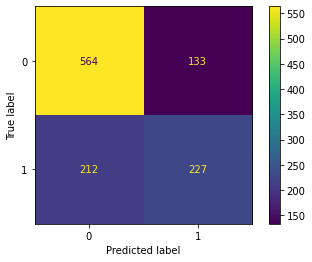

In [27]:
ConfusionMatrixDisplay.from_predictions(predictions_rr['actual_result'], predictions_rr['prediction'])

In [34]:
f1_score(predictions_rr['actual_result'], predictions_rr['prediction'])

0.5682102628285356

In [36]:
#check accuracy of prediction in case one team was predited to win and other was predicted to loose
combined = predictions_rr.merge(full[['date', 'team_x', 'team_y', 'result']], left_index=True, right_index=True)
merged = combined.merge(combined, left_on=['date', 'team_x'], right_on=['date', 'team_y'])
merged[(merged['prediction_x'] == 1) & (merged['prediction_y'] == 0)]['actual_result_x'].value_counts()

1    73
0    42
Name: actual_result_x, dtype: int64

In [37]:
73/(73+42)

0.6347826086956522

### Next steps

1. Gather more data.
2. Try more powerful algorithms e.g XGB Boost
3. Try to transform data to higher dimensions space to check if ther are linearly separable (kernel PCA